# Tutorial: Entendimiento de los datos con PySpark

## Introducción
    ¿Qué aprenderá? 
    En este tutorial aprenderá cómo puede realizar el entendimiento de los datos en el contexto de un proyecto de analítica. A nivel de la metodología ASUM-DM estamos en la fase de entendimiento de datos y en la arquitectura nos encontramos trabajando con el componente de fuentes de datos.

    ¿Qué construirá? 
    En este tutorial realizará la exploración o perfilamiento de un conjunto de datos provenientes de una base de datos relacional, al igual que un análisis de la calidad de los datos utilizando los DataFrames de PySpark. Además, generará las conclusiones requeridas para ser compartidas en reuniones y formalizadas en la documentación del proyecto. Las conclusiones son variadas pero en general podemos decir que siempre deberían incluir una lista de preguntas o aclaraciones para la organización, conclusiones de los datos/problemas de calidad y alternativas para la limpieza. Un entendimiento de datos sin conclusiones no es útil y tampoco es entendible para personas de negocio.
    
    ¿Para qué?
    Antes de realizar cualquier tipo de proyecto de datos es necesario entender los datos con unas tareas de exploración o perfilamiento de datos y de análisis de calidad. Esta fase de la metodología permite determinar si es posible o no realizar el proyecto dada la cantidad y calidad de los datos, el tiempo requerido para su preparación y las diferentes actividades que se requieren para mejorar los datos en caso de requerirse.  
    
    ¿Qué necesita?
    Los siguientes requisitos se encuentran instalados en la máquina virtual asignada a cada estudiante, específicamente en el ambiente de anaconda llamado "Tutoriales". Recuerde que tiene a su disposición el tutorial de conexión a máquinas virtuales en la semana 1 de Coursera
    1. Python 3 con pip instalado
    2. Jupyter Labs
    3. Paquetes: Pyspark (3.2.1), pandas (1.2.1), numpy (1.20.0) y matplotlib (3.3.4)
    Otros:
    1. Controlador Connector J(ya se encuentra configurado)
    2. Acceso a servidor remoto MySQL con base de datos relacional "WWImportersTransactional". Recuerde que tiene a su disposición el tutorial de conexión remoto a Mysql en la semana 1 de Coursera


Continuando con el proyecto de consultoria de Wide World Importers, el primer paso para iniciar la comprensión de los datos es explorar y entender las fuentes de datos disponibles. Note que esto también nos ayuda a comprender mejor la organización.

## Configuración e importe de paquetes
Se utilizará el paquete de pandas profiling para apoyar el análisis estadístico, y se importan los paquetes de python
necesarios

In [126]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np
import pyspark
from pyspark_dist_explore import hist


In [127]:
spark.stop()

Configuración del controlador e inicio de sesion Spark

In [128]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [129]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession


C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [130]:
# Si quiere practicar la conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://ip:8080/WWImportersTransactional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = ':)'
db_psswd = ':D'

PATH='./'

## Perfilamiento de los datos
El perfilamiento se basa en varios aspectos: **entendimiento general** de los datos compartidos, validación de **reglas de negocio**, **análisis descriptivo** utilizando estadística descriptiva y diagramas para la visualización de los datos y **análisis de calidad**. El primero hace referencia a tener una comprensiòn global antes de entrar en los detalles, la segunda sobre las reglas, corresponden a especificaciones dadas por el negocio en relación con los datos, un ejemplo de regla de negocio dada es: "Todo producto de la canasta familiar debe tener un precio de IVA equivalente a 19%", dada esta regla de negocio, se debe revisar en los datos suministrados que no hayan valores de IVA menores a 19%. En el tercer aspecto, relacionado con el análisis descriptivo, se revisan estadísticas: mínimo, máximo, media, mediana, distribuciones de los datos, valores nulos, cardinalidad con el fin de comprender en mayor nivel de profundidad los datos compartidos.


### Información dada por la organización relacionada con los datos
El grupo de consultores de analitica descriptiva de Wide World Importers asegura que las tablas Grupo de compras, Ciudades, Colores, Paises, Clientes, Categorias de clientes, Paquetes, Estados y provincias, Productos y Personas ya fueron perfiladas y corregidos; sin embargo le recomiendan revisar el diccionario suministrado dado que todas las tablas serán utilizadas en futuros requerimientos (tutoriales y ejercicios) que lo encuentra [aqui](./Diccionario%20WWImporters.xlsx). Si tienen alguna duda relacionada con estas tablas deben incluirla en las preguntas o aclaraciones que le entreguen a la organización como parte del resultado de esta fase de entendimiento.

En este punto de la consultorìa, nuestra responsabilidad es analizar las tablas ordenes y detalles de ordenes, relacionadas con al proceso de ordenes de compra de productos. Con respecto a esas fuentes nos comentan lo siguiente:

- La tasa de impuesto es de 10% o 15%
- Son 74.179 órdenes detalladas en 57.981 lineas de detalle de órdenes realizadas desde 2013
- El formato de fechas manejado es YYYY-MM-DD HH:MM:SS si tienen hora, minutos y segundos. De lo contrario el formato es YYYY-MM-DD


### Conexión a fuente de datos y acceso a los datos

#### Conexión a fuente de datos
A continuación encuentra las funciones para conectarse a la fuente de datos (archivo csv o base de datos) y retornar un dataframe que es el que se utilizará posteriormente para manipular los datos.

In [131]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

#### Cargue de datos
Para consultar desde la base de datos se puede acceder directamente a la tabla dado su nombre o se puede especificar la sentencia SQL de un "SELECT" completo para traer la información total o parcial de la tabla que se requiere. A continuación un ejemplo de cada uno de estos usos. 
Acceso directo para el caso de órdenes y acceso con sentencia SQL para el caso de detallesOrdenes.

In [132]:
sql_ordenes = 'WWImportersTransactional.OrdenesCopia'

In [133]:
sql_detallesOrdenes = '''(SELECT 
        Detalle_orden_ID, 
        ID_de_pedido, 
        ID_Producto, 
        Descripcion, 
        ID_Tipo_Paquete, 
        Cantidad, 
        Precio_unitario, 
        Tasa_de_impuesto, 
        Cantidad_seleccionada, 
        Seleccion_completada_cuando 
        FROM WWImportersTransactional.DetallesOrdenesCopia) AS Compatible'''

In [134]:
#Se cargan los dataframes desde la base de datos
ordenes = obtener_dataframe_de_bd(db_connection_string, sql_ordenes, db_user, db_psswd)
detallesOrdenes = obtener_dataframe_de_bd(db_connection_string, sql_detallesOrdenes, db_user, db_psswd)

### Entendimiento general de datos

Para ver una muestra de los datos, utilice el comando <i>show</i> ingresando el número de filas que quiere ver

In [135]:
ordenes.show(5)

+------------+-------------+--------------+------------------------------+-------------------------+----------------------+---------------+-------------------------+--------------------------------------+-------------------------------------------+-----------+------------------------+--------------------+---------------------------+
|ID_de_pedido|ID_de_cliente|ID_de_vendedor|Seleccionado_por_ID_de_persona|ID_de_persona_de_contacto|ID_de_pedido_pendiente|Fecha_de_pedido|Fecha_de_entrega_esperada|Numero_de_pedido_de_compra_del_cliente|Pedido_pendiente_de_suministro_insuficiente|Comentarios|Instrucciones_de_entrega|Comentarios_internos|Seleccion_completada_cuando|
+------------+-------------+--------------+------------------------------+-------------------------+----------------------+---------------+-------------------------+--------------------------------------+-------------------------------------------+-----------+------------------------+--------------------+------------------------

In [136]:
detallesOrdenes.show(5)

+----------------+------------+-----------+--------------------+---------------+--------+---------------+----------------+---------------------+---------------------------+
|Detalle_orden_ID|ID_de_pedido|ID_Producto|         Descripcion|ID_Tipo_Paquete|Cantidad|Precio_unitario|Tasa_de_impuesto|Cantidad_seleccionada|Seleccion_completada_cuando|
+----------------+------------+-----------+--------------------+---------------+--------+---------------+----------------+---------------------+---------------------------+
|          206857|       65697|        205|Tape dispenser (B...|              7|      60|             32|              15|                   60|        2016-01-27 11:00:00|
|          206858|       65698|         45|Developer joke mu...|              7|       3|             13|              15|                    3|        2016-01-27 11:00:00|
|          206859|       65698|         72|Ride on toy sedan...|              7|       3|            230|              15|             

Como puede observar en la tabla de ordenes tenemos información **relacionada con el cliente, el empleado y con la órden**. La información del cliente es su identificador <i>ID_de_cliente</i>, el identificador de la persona que eligió la órden <i>eleccionado_por_ID_de_persona</i>, el identificador de la persona de contacto <i>ID_de_persona_de_contacto</i>, el <i>Número_de_pedido_de_compra_del_cliente</i>. La información del empleado es su identificador <i>ID_de_vendedor</i>. La información de la órden es: el identificador de la órden <i>ID_de_pedido</i>, el identificador que indica si es un pedido pendiente <i>ID_de_pedido_pendiente</i>, la fecha en la que se realizó el pedido <i>Fecha_de_pedido</i>, la fecha de entrega esperada del pedido <i>Fecha_de_entrega_esperada</i> y <i>Pedido_pendiente_de_suministro_insuficiente</i> que indica si es un pedido pendiente o no.
El esquema de un DataFrame incluye los nombres de las columnas asi como el tipo de dato. Recuerde que tipo de dato (e.g., booleano, caracteres, enteros, flotantes, colecciones) es diferente a tipo de variable (numérica y categórica).

In [137]:
ordenes.schema

StructType(List(StructField(ID_de_pedido,IntegerType,true),StructField(ID_de_cliente,IntegerType,true),StructField(ID_de_vendedor,IntegerType,true),StructField(Seleccionado_por_ID_de_persona,IntegerType,true),StructField(ID_de_persona_de_contacto,IntegerType,true),StructField(ID_de_pedido_pendiente,IntegerType,true),StructField(Fecha_de_pedido,StringType,true),StructField(Fecha_de_entrega_esperada,StringType,true),StructField(Numero_de_pedido_de_compra_del_cliente,StringType,true),StructField(Pedido_pendiente_de_suministro_insuficiente,BooleanType,true),StructField(Comentarios,StringType,true),StructField(Instrucciones_de_entrega,StringType,true),StructField(Comentarios_internos,StringType,true),StructField(Seleccion_completada_cuando,TimestampType,true)))

Por otra parte, en los detalles de ordenes se tiene **información del pedido y del producto**. Del pedido se tiene el identificador del detalle <i>Detalle_orden_ID</i>, el identificador de la orden a la que está relacionado cada detalle <i>ID_de_pedido</i>, la <i>Cantidad_seleccionada</i> del producto para la orden, la fecha de selección <i>Seleccion_completada_cuando</i>. Del producto tenemos el <i>ID_Producto</i>, su <i>Descripcion</i>, el tipo de paquete <i>ID_Tipo_Paquete</i> (Ej. 1.Bolsa, 4. Caja), la <i>Cantidad</i>, el <i>Precio_unitario</i>, y la <i>Tasa_impuesto</i> asociada a ese producto. Una primera aclaración a solicitar por parte del negocio es cuál es la diferencia entre cantidad y cantidad seleccionada

In [138]:
detallesOrdenes.schema

StructType(List(StructField(Detalle_orden_ID,IntegerType,true),StructField(ID_de_pedido,IntegerType,true),StructField(ID_Producto,IntegerType,true),StructField(Descripcion,StringType,true),StructField(ID_Tipo_Paquete,IntegerType,true),StructField(Cantidad,IntegerType,true),StructField(Precio_unitario,DecimalType(10,0),true),StructField(Tasa_de_impuesto,DecimalType(10,0),true),StructField(Cantidad_seleccionada,IntegerType,true),StructField(Seleccion_completada_cuando,TimestampType,true)))

**¿Qué es una fila de cada fuente compartida?**
Con estos análisis podemos concluir que una fila de órdenes representa la órden realizada por un cliente y atendida por un empleado. Mientras que el detalle de órden coincide con su nombre y contiene el detalle de cada producto solicitado en una órden.

Una vez entendida en términos generales la estructura de los datos, es necesario conocer la cantidad de datos disponibles, esto se hace con count() y con columns, que retornan el número de filas y número de columnas respectivamente.

In [139]:
print((detallesOrdenes.count(), len(detallesOrdenes.columns)),(ordenes.count(), len(ordenes.columns)))

(58320, 10) (88258, 14)


**¿Cuantos datos nos compartieron para el proyecto?**
En total tenemos 58.320 detalles de orden  y 88.258 órdenes y tenemos en total 24 variables a revisar de las cuales 8 son nùmericas asociadas a las órdenes, dos son de tipo fecha y las demás son cadenas de caracteres.

### Revisión de reglas de negocio 

Primero se confirman las reglas proporcionadas por el negocio, la primera que asegura que la tasa de impuesto es de 10% o 15% vemos que no es correcta pues al seleccionar esa columna e indicar que queremos ver los valores distintos que puede tomar se observa únicamente el valor 15

In [140]:
detallesOrdenes.select("Tasa_de_impuesto").distinct().show()

+----------------+
|Tasa_de_impuesto|
+----------------+
|              15|
+----------------+



Si se quiere saber cuántos registros hay por cada valor posible, existen varias formas de hacerlo, en la siguiente celda se muestra cómo iterar sobre los valores resultado de una consulta y cómo filtrar el número de registros para cada valor usando filter y select where, también se da un ejemplo de uso de group by y agregaciones

Pyspark tiene funcionalidades de los DataFrames que permiten explorar los datos por medio de agregaciones y estas funcionan similar a como se usan en SQL

Primero, se debe agrupar sobre una columna con el método <i>groupBy</i> y después se pueden realizar agregaciones sobre otras columnas con el método <i>agg</i>. La sintaxis es la siguiente: 
 ``` 
    DataFrame.groupBy('COLUMN NAME').agg({'COLUMN NAME 1': 'mean', 'COLUMN NAME 2': 'count', 'COLUMN NAME 3': 'max'})
  ``` 

En cualquiera de los 3 casos se observa que el resultado es el mismo

In [141]:
for row in detallesOrdenes.select('Tasa_de_impuesto').distinct().collect(): 
    texto = 'número de registros con '+str(row.Tasa_de_impuesto)+ '% de tasa de impuesto: '
    opc1 ="--Usando filter--"
    print(texto+opc1+str(detallesOrdenes.filter(col('Tasa_de_impuesto')==row.Tasa_de_impuesto).count()))
    
    opc2 ="--Usando Select where--"
    print(texto+opc2+str(detallesOrdenes.select().where(col('Tasa_de_impuesto')==row.Tasa_de_impuesto).count()))
    opc3 ="--Usando group by--"
detallesOrdenes.groupBy("Tasa_de_impuesto").count().show()

número de registros con 15% de tasa de impuesto: --Usando filter--58320
número de registros con 15% de tasa de impuesto: --Usando Select where--58320
+----------------+-----+
|Tasa_de_impuesto|count|
+----------------+-----+
|              15|58320|
+----------------+-----+



La conclusión es entonces que la regla no es completamente cierta, pues en los datos no hay ningun registro con tasa_de_impuesto de 10%, es necesario pedir aclaraciones al negocio en relación a este descubrimiento. La segunda regla de negocio implica conocer el número de registros y de variables que los describen, es decir, el número de filas y columnas del DataFrame respectivamente, esto se logra usando count() y columns

In [142]:
print((detallesOrdenes.count(), len(detallesOrdenes.columns)),(ordenes.count(), len(ordenes.columns)))

(58320, 10) (88258, 14)


Podemos concluir que esta regla de negocio no es cierta dado que el número de registros no parece coincidir con el número dado por el negocio, una primera intuición nos dice que podrían haber registros duplicados y si existen hay que reportarlos y eliminarlos en la fase de preparación de los datos. Esta es la primera conclusión del análisis de entendimiento de datos.

In [143]:
detallesOrdenes.distinct().count(), ordenes.distinct().count() 

(58239, 74179)

Como pueden ver hay 58.239 detalles de orden y 74.179 ordenes únicas. Es decir que sabemos que hay 14.079 ordenes completamente repetidas, pero entonces ¿por qué el número de detalles de orden que hay en los datos no coincide con el dado por la organización? 

La respuesta es que no basta solo con revisar si hay registros idénticos, puede que hayan registros con columnas identificadoras o lo que conoceriamos como las llaves primarias repetidas pero con diferentes valores en los otros atributos. Esto se da principalmente cuando las bases de datos están mal construidas, aunque hay casos en los cuales tiene sentido. En cualquier caso es nuestra responsabilidad preveer estos escenarios, por ende se revisan los datos por la llave primaria de esta tabla:

In [144]:
detallesOrdenes.select(col('Detalle_orden_ID')).distinct().count()

57981

De esta manera vemos que hay una diferencia de 258 registros cuyo identificador es el mismo y vemos que el número de identificadores únicos coincide con el número dado por el negocio, la segunda conclusión es entonces que tenemos 258 registros que representan el mismo detalle de orden pero con valores distintos.

Lo siguiente es verificar las fechas en los datos, nos dicen que son ordenes desde 2013 por lo que se revisa la fecha mínima del atributo Fecha_de_pedido, como se observa la fecha mínima es de 2014 enero 1, esto nos indica que la regla de negocio no es correcta o faltan datos, esta es la tercera conclusión

In [145]:
ordenes.agg({"Fecha_de_pedido": "min"}).show()

+--------------------+
|min(Fecha_de_pedido)|
+--------------------+
|          2014-01-01|
+--------------------+



 ``` 
Como ve en el comando anterior las agregaciones también se pueden realizar sin un groupBy.
 ``` 

La siguiente regla nos indica que es necesario revisar el formato de las fechas YYYY-MM-DD HH:MM:SS, un ejemplo es el atributo <i>Fecha_de_pedido</i>. Para esto vamos a hacer uso de expresiones regulares, que son patrones de búsqueda, en este caso queremos 4 dígitos entre 0 y 9 que indican el año seguido del símbolo - luego tenemos un número de 2 dígitos que puede empezar con 0 seguido de un número entre 1 y 9 (meses 01 hasta 09) o 1 seguido de 1 o 2 (meses 11 o 12), sigue otro -, y terminamos con un número de 2 dígitos que van desde el día 01 hasta el 31, se usa rlike smilar a LIKE de SQL

In [146]:
regex = "[0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])"
cumplenFormato = ordenes.filter(ordenes["Fecha_de_pedido"].rlike(regex))
print("Número total de ordenes: "+str(ordenes.count())+", número de ordenes con formato correcto: "+str(cumplenFormato.count()))

Número total de ordenes: 88258, número de ordenes con formato correcto: 68223


Para ver los registros que no cumplen con el formato podemos negar la condición del filtro con el símbolo ~ al principio:

In [147]:
noCumplenFormato = ordenes.filter(~ordenes["Fecha_de_pedido"].rlike(regex))
noCumplenFormato.count(), noCumplenFormato.select(col("Fecha_de_pedido")).show()

+---------------+
|Fecha_de_pedido|
+---------------+
|    Mar 05,2015|
|    Mar 24,2015|
|    Mar 18,2014|
|    Apr 21,2015|
|    Nov 11,2014|
|    Oct 16,2014|
|    May 04,2015|
|    Nov 24,2014|
|    May 07,2015|
|    Sep 10,2014|
|    Nov 03,2015|
|    Dec 19,2014|
|    Apr 27,2016|
|    Apr 28,2016|
|    Sep 23,2014|
|    Oct 02,2015|
|    Jun 11,2014|
|    Feb 17,2014|
|    Aug 14,2015|
|    Dec 25,2015|
+---------------+
only showing top 20 rows



(20035, None)

Concluimos entonces, que hay 20.035 registros cuya fecha no cumple con el formato especificado. Sin embargo, los valores que son diferentes parecen serlo solo porque varia el formato, este tipo de casos pueden ser solucionados fácilmente por lo que una notificación al negocio sería con caracter informativo más que para solicitar una aclaración de su parte.

Para facilitar los análisis y evitar inconsistencias o conclusiones erradas vamos a estandarizar los datos, en este caso las fechas. Sin embargo, esta actividad puede hacerse sobre formatos de números, texto entre otras. 

Algo que se debe tener en cuenta en el perfilamiento de reglas de negocio es que dichas reglas pueden estar incompletas, por ende se recomienda tener especial cuidado con las columnas tipo caracter o string dado que suelen ser pasadas por alto en el análisis estadistico, un ejemplo es la columna **Descripcion**, al ser una columna de descripción del producto se espera que tenga un cierto número de caracteres. Sin embargo haciendo la validación vemos que algunas descripciones son textos incompletos como "a". Este podría llegar a ser un problema a futuro por lo que se decide notificar a la organización.

In [148]:
detallesOrdenes.where(length(col("Descripcion")) <= 10).show()

+----------------+------------+-----------+-----------+---------------+--------+---------------+----------------+---------------------+---------------------------+
|Detalle_orden_ID|ID_de_pedido|ID_Producto|Descripcion|ID_Tipo_Paquete|Cantidad|Precio_unitario|Tasa_de_impuesto|Cantidad_seleccionada|Seleccion_completada_cuando|
+----------------+------------+-----------+-----------+---------------+--------+---------------+----------------+---------------------+---------------------------+
|          206862|       65698|         10|          a|              7|       5|             32|              15|                    5|        2016-01-27 11:00:00|
|          206874|       65701|         47|          a|              7|       5|             13|              15|                    5|        2016-01-27 11:00:00|
|          206909|       65711|         37|          a|              7|       5|             13|              15|                    5|        2016-01-27 11:00:00|
|          20691

### Análisis descriptivo
Una vez cubierto lo básico de reglas de negocio, pasamos a perfilamiento estadístico. Para ver estadisticos generales como conteo, mínimo, máximo, desviación estandar y percentiles utilice summary()

In [149]:
ordenes.summary().show()

+-------+-----------------+-----------------+-----------------+------------------------------+-------------------------+----------------------+---------------+-------------------------+--------------------------------------+-----------+------------------------+--------------------+
|summary|     ID_de_pedido|    ID_de_cliente|   ID_de_vendedor|Seleccionado_por_ID_de_persona|ID_de_persona_de_contacto|ID_de_pedido_pendiente|Fecha_de_pedido|Fecha_de_entrega_esperada|Numero_de_pedido_de_compra_del_cliente|Comentarios|Instrucciones_de_entrega|Comentarios_internos|
+-------+-----------------+-----------------+-----------------+------------------------------+-------------------------+----------------------+---------------+-------------------------+--------------------------------------+-----------+------------------------+--------------------+
|  count|            88258|            88258|            88258|                         74688|                    88258|                  9223|        

En las estadísticas anteriores vemos que las columnas Comentarios, Instrucciones_de_entrega y Comentarios_internos tienen un conteo igual a 0, es decir son columnas vacías por lo que s epueden eliminar, también observamos el calculo de la media para las columnas ID, esto se hace automatico pues son columnas cuyo tipo de dato es numerico, sin embargo estas no son variables numericas por lo cual calcular y/o analizar la media no tiene sentido. La lógica es similar para los otros estadísticos, aunque podemos decir que los ID's de pedido van desde el número 19443 hasta el 73595 por ejemplo

In [150]:
detallesOrdenes.summary().show()

+-------+------------------+------------------+------------------+--------------------+---------------+------------------+-----------------+----------------+---------------------+
|summary|  Detalle_orden_ID|      ID_de_pedido|       ID_Producto|         Descripcion|ID_Tipo_Paquete|          Cantidad|  Precio_unitario|Tasa_de_impuesto|Cantidad_seleccionada|
+-------+------------------+------------------+------------------+--------------------+---------------+------------------+-----------------+----------------+---------------------+
|  count|             58320|             58320|             58320|               58320|          58320|             58320|            57337|           58320|                58320|
|   mean|152909.77184499314| 91440.73607681756|111.83144718792867|                null|            7.0|213.03914609053498|          44.5468|         15.0000|    39.74422153635117|
| stddev| 72929.99490225241|29085.094720342793| 64.32670239320214|                null|            0

En las estadíticas de orden podemos observar que el valor promedio de precio unitario es 44.54, la cantidad promedio es 213 unidades y el promedio de cantidad seleccionada es 39.74

En cuanto a la desviación estandar vemos que, por ejemplo, el precio unitario puede variar en más o menos 139.45. El valor mínimo de cantidad es 1 y el máximo es 10'000.000, de cantidad seleccionada el mínimo es 0 y el máximo 360 y de precio unitario el mínimo es 1 y el máximo 1899. Vemos por ejemplo que el valor máximo de Cantidad indica valores anómalos o extremos, pues en su percentil 75% el valor máximo era 70, es decir, para el 75% de los datos, el valor de Cantidad no superaba el 70. Observamos que la columna ID_Tipo_Paquete solo toma el valor 7, que podría ser o no un error, se notifica al negocio.

Otras formas de observar distribución o estadísticos son las graficas, de barras, de dispersión, diagramas de caja, entre otros. Por ejemplo tenemos los siguientes diagramas de caja donde se observa claramente que tenemos un valor extremo en la variable cantidad (primer grafico) y donde podemos ver los valores extremos o bigotes que determinan el punto de separación entre valores atípicos y normales, los valores atipicos, los cuartiles entre otros

{'whiskers': [<matplotlib.lines.Line2D at 0x1f75541ed08>,
 'caps': [<matplotlib.lines.Line2D at 0x1f6a230f148>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f750798d88>],
 'medians': [<matplotlib.lines.Line2D at 0x1f6a31d5dc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f6a2ac98c8>],
 'means': []}

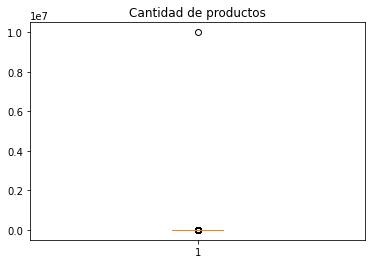

In [151]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('Cantidad de productos')
ax1.boxplot(np.array(detallesOrdenes.select('Cantidad').collect()))

{'whiskers': [<matplotlib.lines.Line2D at 0x1f755985308>,
 'caps': [<matplotlib.lines.Line2D at 0x1f7559acb08>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f755985508>],
 'medians': [<matplotlib.lines.Line2D at 0x1f755986d08>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f755986588>],
 'means': []}

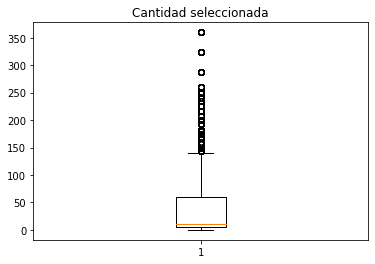

In [152]:
fig1, ax1 = plt.subplots()
ax1.set_title('Cantidad seleccionada')

my_list = [float(i) for i in detallesOrdenes.select(f.collect_list('Cantidad_seleccionada')).first()[0]]
ax1.boxplot(my_list)

El análisis anterior es muy útil para variables de tipo numérico, sin embargo es incompleto para las variables de tipo caracter o las variables categoricas, por ende es necesario implementar nuestro propio código par obtener estadisticos como la moda y la mediana. A continuación obtenemos la moda para la variable Descripcion:

In [153]:
detallesOrdenes.groupby("Descripcion").count().orderBy("count", ascending=False).show(5)

+--------------------+-----+
|         Descripcion|count|
+--------------------+-----+
|                   a| 3225|
|Halloween skull m...|  306|
|Large  replacemen...|  305|
|"The Gu" red shir...|  303|
|"The Gu" red shir...|  296|
+--------------------+-----+
only showing top 5 rows



## Análisis de calidad de datos
La calidad de los datos consiste en validar la idoneidad de los datos analizando varias dimensiones, entre las cuales resaltamos:
- Completitud: Datos que no existen o no se conocen
- Unicidad (Duplicidad): Datos que son idénticos en diferentes registros o registros con valores idénticos en atributos en los que no debería ocurrir
- Consistencia: Esta medida se define por la validez o integridad del dato, en la definición de su estructura, al interior de una fila o entre diferentes filas de la misma fuente o de diferentes fuentes. El manejo de unidades en los datos y el significado del dato son generadores de inconsistencias.
- Validez: a nivel de formato y de sentido de los datos más alla de sus valores

Para asegurar una calidad mínima de los datos en estas dimensiones hay que entender su origen y posteriormente realizar un proceso de validación de cada una de las dimensiones de perfilamiento que llevará a un entendimiento de los datos disponibles.


A continuación se definen dos funciones, la primera cuenta los valores vacios por columna de dataframe, la segunda retorna un diccionario de columnas con cardinalidad superior al 50%

Te invito a revisar los recursos de calidad de datos que hemos visto en el curso, a continuacion ejemplos daremos algunos ejemplos por cada dimensión para el caso del tutorial

### Unicidad y validez

La unicidad se revisó en la segunda regla de negocio y la validez se reviso en el perfilamiento general, en la regla de negocio 3 y en el análisis de la descripción al final de la sección de revisión de reglas de negocio

### Completitud y validez

In [154]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c].isNull()).count()
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [155]:
columnas_vacias_ordenes = contar_vacios(ordenes)
print('detalles de ordenes: ')
columnas_vacias_detalles = contar_vacios(detallesOrdenes)

número de vacíos para columna Seleccionado_por_ID_de_persona: 13570
número de vacíos para columna ID_de_pedido_pendiente: 79035
número de vacíos para columna Comentarios: 88258
número de vacíos para columna Instrucciones_de_entrega: 88258
número de vacíos para columna Comentarios_internos: 88258
número de vacíos para columna Seleccion_completada_cuando: 4347
detalles de ordenes: 
número de vacíos para columna Precio_unitario: 983
número de vacíos para columna Seleccion_completada_cuando: 982


In [156]:
columnas_alta_cardinalidad_ordenes = cardinalidad(ordenes)
columnas_alta_cardinalidad_detalles = cardinalidad(detallesOrdenes)
columnas_alta_cardinalidad_ordenes, columnas_alta_cardinalidad_detalles

({'ID_de_pedido': 54145}, {'Detalle_orden_ID': 57981, 'ID_de_pedido': 38742})

Como podemos observar para las ordenes las columnas Seleccionado_por_ID_de_persona tiene 13750 vacios, ID_de_pedido_pendiente: 79035, Comentarios: 88258, Instrucciones_de_entrega: 88258, Comentarios_internos: 88258, Seleccion_completada_cuando: 4347, mientras que para los detalles de ordenes tenemos que las columnas con vacios son Precio_unitario: 983 y Seleccion_completada_cuando: 982. 

Respecto a cardinalidad, solo la columna Detalle_orden_ID tiene una cardinalidad superior al 50%.

### Consistencia
A nivel de consistencia algunos ejemplos de revisión son precios negativos, productos que aparecen en las ordenes pero que no esten registrados en la tabla de produtos. En nuestro caso vamos a verificar que todas las ordenes tengan detalle de orden y viceversa

In [157]:
#consistencia: revisar genially: definicion de consistencia
ids_ordenes = set([x.ID_de_pedido for x in ordenes.select('ID_de_pedido').collect()])
ids_detalles = set([x.ID_de_pedido for x in detallesOrdenes.select('ID_de_pedido').collect()])

len(ids_ordenes-ids_detalles), len(ids_detalles-ids_ordenes)

(44359, 28956)

Como se puede observar hay una diferencia de 44.359 ordenes que no tienen detalles y hay 28.956 detalles que no tienen orden. Ninguno de los casos tiene sentido en el contexto de WideWorldImporters. Esta inconsistencia se notifica al negocio dado que no hay forma de conocer cuáles son los registros que pueden tener ids que no existen

## Herramientas para facilitar el entendimiento de datos

Algunas de las estadísticas antes desarrolladas pueden obtenerse por medio de herramientas como Pandas Profiling una herramienta muy útil, <b><i>Pero no perfecta ni completa</i></b>, es Pandas profiling que dado un conjunto de datos, nos muestra histogramas, estadísticas etc. A continuación guardamos el reporte en html

In [158]:
reporte = ProfileReport(ordenes.toPandas())
reporte.to_file(PATH+"reporte_prefilamiento.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 31.11it/s]


Lo primero que hay que notar es que hay 3 secciones principales. La primera es un resumen, la segunda es un análisis por cada variable y luego tenemos interacciones y correlaciones entre variables. 

Seccion general del reporte:
1. Tenemos 14 variables y 88.258 registros (es decir, ordenes), de las cuales 7 son numericas, 2 categoricas, 1 booleana, 1 datetime y 3 no soportadas (la herramienta entiende tipo de variable como tipo de dato, asi que la información que nos da no es necesariamente correcta en este aspecto).

2. En los datos hay 29.3% de datos vacíos, (conclusión)

3. El archivo ocupa en memoria 7.5 MB

4. No hay registros duplicados

Sección de variables del reporte:

5. Note que para cada variable nos dan estadisticos como la media, mínimo y máximo asi como un histograma de distribución de la variable, para nuestros datos no observamos nada por fuera de lo comun. (Como valores extremos)

6. La variable ID_de_pedido tiene 61.3% de valores distintos, es decir, es una variable con alta cardinalidad. Este tipo de variables no aportan a las relaciones entre filas o columnas, por lo que suelen no ser útiles a la hora de hacer análitica.

7. La variable ID_cliente tiene solo el 0,8% de valores distintos, es decir que las ordenes que tenemos parecen ser de pocos clientes, pero que podrían ser recurrentes o fieles

8. Hay 10 empleados en los datos de ordenes

9. Seleccionado_por_ID_persona tiene 15,4% de datos vacíos, no es muy alto pero podríamos eliminarla si no es importante. Preguntar al negocio

10. ID_de_pedido_pendiente tiene un porcentaje de 89,5% de valores vacíos, es casi constante y las columnas constantes no aportan a los análisis, preguntar al negocio si hay algún inconveniente en borrar esta columna

11. Hay 1512 Fecha_de_pedido distintos, siendo el 3 de febrero del 2015 una de las fechas con más número de ordenes

12. Fecha_de_entrega_esperada y Seleccion_completada_cuando tienen alta cardinalidad

Sección de interacciones y correlaciones:

Parecen haber columnas con correlaciones(Spearman) iguales a 1, esto significa que ambas columnas representan la misma información, idealmente no queremos columnas "repetidas", un ejemplo es ID_cliente y ID_de_persona_de_contacto, decidimos preguntarle al negocio si es necesario mantener ambas columnas

<b>Cabe aclarar que un pandas profiling sin interpretación no es suficiente como análisis para realizar el entendimiento de los datos.

Así mismo, recuerde que si es necesario, se debe utilizar otra herramienta (código, visualizaciones, etc) para poder completar el análisis estadístico.</b>

### Algunas gráficas utiles: Diagrama de caja, dispersion, histogramas para entender las distribuciones de las variables

Generalmente las gráficas se emplean para entender la distribución de cada variable, también sirven para visualizar la relación entre 2 o más variables

Algunas gráficas útiles son los histogramas, disepersión, diagramas de caja. Hay varias maneras de implementarlos, con paquetes como matplotlib o pandas, con funciones propias de pyspark, etc, a continuacón mostramos cómo hacerlo a travez de pandas

array([[<AxesSubplot:title={'center':'Cantidad_seleccionada'}>]],
      dtype=object)

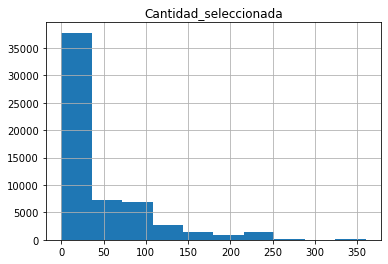

In [159]:
#para valores extremos(subir a calidad)
detallesOrdenes.toPandas().hist(column='Cantidad_seleccionada')

In [160]:
cantidades = detallesOrdenes.groupby("Cantidad").count().orderBy("count", ascending=False)

Como se puede observar, el método retorna un dataframe, que vamos a usar para obtener dos arreglos, uno con el rango de cada una de las barras y otro con la cantidad de registros por rango. Se puede usar Matplotlib para graficar esta información:

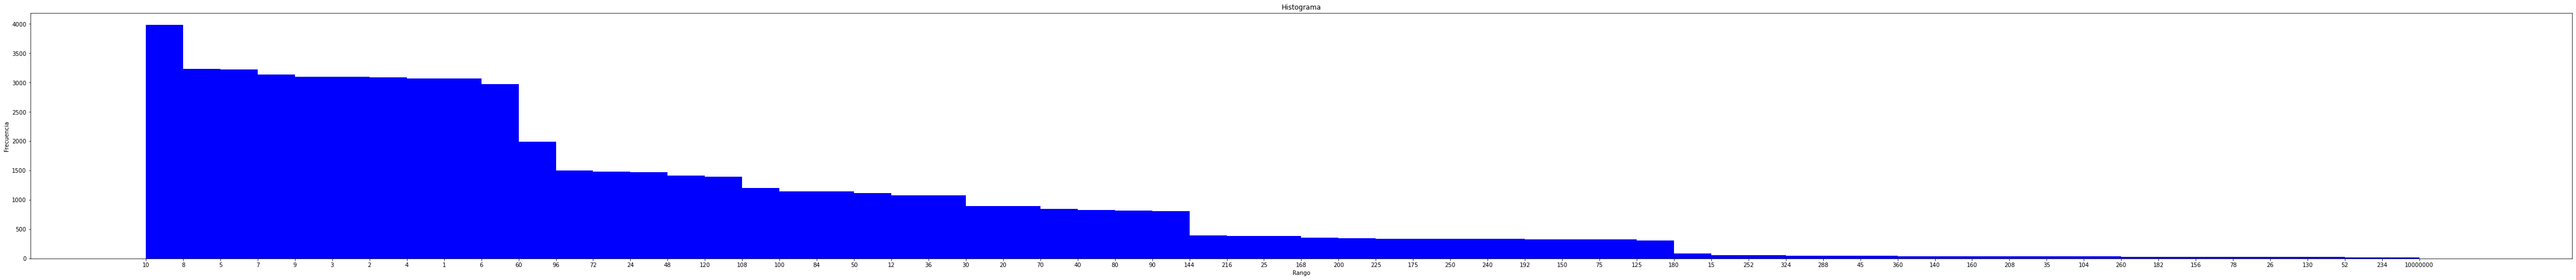

In [161]:
def plotHistogramData(data):
    binSides, binCounts = [row[0] for row in data.collect()], [row[1] for row in data.collect()]
    binSides = [round(i, 2) for i in binSides]
    N = len(binCounts)
    ind = np.arange(N)
    width = 1

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind+0.5, binCounts, width, color='b')
    
    fig.set_size_inches(1.3*N, 8)

    ax.set_ylabel('Frecuencia')
    ax.set_xlabel('Rango')
    ax.set_title('Histograma')
    ax.set_xticks(np.arange(N))
    ax.set_xticklabels(binSides)

    plt.show()

plotHistogramData(cantidades)

El diagrama de dispersion, nos muestra los datos para dos variables en forma de puntos y es muy útil para entender la relación entre dichas variables

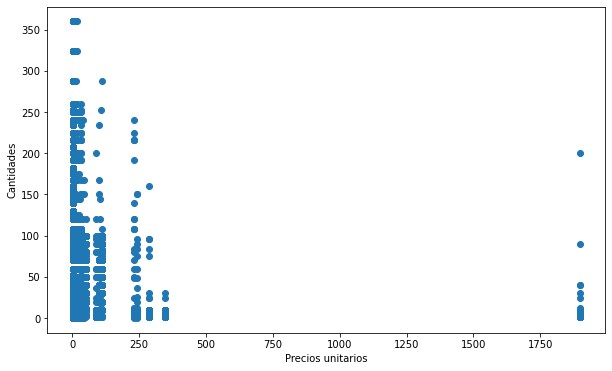

In [162]:
unitPrices = [row['Precio_unitario'] for row in detallesOrdenes.select(col('Precio_unitario')).collect()]
quantities = [row['Cantidad_seleccionada'] for row in detallesOrdenes.collect()]

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = unitPrices, y = quantities)
plt.xlabel("Precios unitarios")
plt.ylabel("Cantidades")

plt.show()

### Otras opciones de exploración
PySpark también da la opción de crear tablas de pivotes. En el siguiente ejemplo, se muestra cómo hacer una tabla que permite ver cuántas ordenes hay por cada <i>Fecha_de_pedido</i> y por cada <i>ID_de_vendedor</i>, es decir por fecha y por empleado cuantas ordenes existen:

In [163]:
ordenes.groupBy('Fecha_de_pedido').pivot('ID_de_vendedor').count().show()

+---------------+----+---+---+----+----+----+---+----+---+----+
|Fecha_de_pedido|   2|  3|  6|   7|   8|  13| 14|  15| 16|  20|
+---------------+----+---+---+----+----+----+---+----+---+----+
|     2014-12-13|   7|  8|  7|   5|   3|   6|  7|   6|  2|   6|
|     2014-05-27|   6|  7|  8|   6|   2|  11|  6|   5| 13|   6|
|     2014-02-22|   6|  4|  2|   6|   4|   3|  2|null| 11|   7|
|     2015-05-01|  22| 13| 17|   2|  14|  13|  9|  11| 19|  16|
|    Feb 27,2014|   5|  3|  6|   1|   3|null|  3|   3|  7|   1|
|     2015-02-09|   2| 13| 15|  18|   8|   6|  6|   7| 15|  15|
|    Sep 21,2015|   2|  6|  7|   6|   2|   2|  3|   3|  3|   2|
|     2014-07-14|  13| 10| 15|   7|   5|  13| 15|  10| 17|  12|
|    Jul 26,2014|   2|  2|  3|   3|   1|   1|  3|null|  1|   2|
|    May 14,2016|null|  3|  2|   5|   1|   4|  3|null|  1|   3|
|    Aug 22,2015|   1|  1|  2|   4|null|   2|  2|   2|  5|   1|
|     2014-12-11|  13| 18|  4|   4|   9|  10|  2|  11|  5|   2|
|     2015-02-27|  19| 14| 10|  10|  22|

Otro análisis muy útil es el de la correlación lineal entre dos variables, para ver la matriz de correlacion que mide esta dependencia o la fuerza de la relación lineal entre dos variables vamos a usar pandas, la interpretación es que si entre dos variables A y B  el valor obtenido es cercano a -1 o a 1, se interpreta como que A y B contienen la misma información y por ende no es necesario mantener ambas columnas

In [164]:
corr = detallesOrdenes.toPandas().corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pandas\io\formats\style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pandas\io\formats\style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Detalle_orden_ID,ID_de_pedido,ID_Producto,ID_Tipo_Paquete,Cantidad,Cantidad_seleccionada
Detalle_orden_ID,1.000000,0.052772,0.022949,nan,0.003160,0.003761
ID_de_pedido,0.052772,1.000000,-0.007438,nan,-0.003613,-0.008976
ID_Producto,0.022949,-0.007438,1.000000,nan,0.002252,0.513602
ID_Tipo_Paquete,nan,nan,nan,nan,nan,nan
Cantidad,0.003160,-0.003613,0.002252,nan,1.000000,-0.001033
Cantidad_seleccionada,0.003761,-0.008976,0.513602,nan,-0.001033,1.000000


## Conclusiones/resultados


**Conclusiones generales:**

1. En la tabla de ordenes tenemos información **relacionada con el cliente, el empleado y con la órden**. Por otra parte, en los detalles de ordenes se tiene **información del pedido y del producto**
2. Una fila de órdenes representa la órden realizada por un cliente y atendida por un empleado. Mientras que el detalle de órden coincide con su nombre y contiene el detalle de cada producto solicitado en una órden.
3. ¿cuál es la diferencia entre cantidad y cantidad seleccionada?

**Conclusiones de reglas de negocio:**

1. La regla 1 no es completamente cierta, pues en los datos no hay ningun registro con tasa_de_impuesto de 10%, es necesario pedir aclaraciones al negocio en relación a este descubrimiento
2. La regla 2 no es cierta dado que el número de registros no parece coincidir con el número dado por el negocio, Hay 14.079 ordenes completamente repetidas y 258 registros que representan el mismo detalle de orden pero con valores distintos, los primeros se pueden eliminar, pero ¿qué deberíamos hacer con los segundos?
3. Los datos comienzan en enero 1 de 2014, sin embargo la regla 2 nos dice que debería ser desde 2013, ¿es un error o faltan datos?
4. Algunos formatos de fecha no coinciden con el dado en la regla 3, por ejemplo del atributo Fecha_de_pedido hay 20 mil registros que no tienen ese formato. En este caso el cambio de formato se puede implementar, ¿estan de acuerdo?
5. La descripcion de algunos productos es "a", ¿esto es correcto?

**Conclusiones de calidad:**

1. Las columnas Comentarios, Instrucciones_de_entrega y Comentarios_internos tienen un conteo igual a 0, es decir son columnas vacías por lo que se pueden eliminar
2. Vemos por ejemplo que el valor máximo de Cantidad indica valores anómalos o extremos, pues en su percentil 75% el valor máximo era 60, es decir, para el 75% de los datos, el valor de Cantidad no superaba el 70, pero el valor máximo es de 10 millones
3. Observamos que la columna ID_Tipo_Paquete solo toma el valor 7, que podría ser o no un error, se notifica al negocio.
4. Para las ordenes las columnas Seleccionado_por_ID_de_persona tiene 16662 vacios, ID_de_pedido_pendiente: 96905, Comentarios: 108291, Instrucciones_de_entrega: 108291, Comentarios_internos: 108291, Seleccion_completada_cuando: 5276, mientras que para los detalles de ordenes tenemos que las columnas con vacios son Precio_unitario: 7038 y Seleccion_completada_cuando: 3186.
5. Respecto a cardinalidad, solo la columna Detalle_orden_ID tiene una cardinalidad superior al 50%.
6. Como se puede observar hay una diferencia de 44.359 ordenes que no tienen detalles y hay 28.956 detalles que no tienen orden. Ninguno de los casos tiene sentido en el contexto de WideWorldImporters. ¿Tienen alguna forma de identificar cual detalle corresponde a cual orden?

**Usando herramientas:**

Seccion general del reporte:
1. Tenemos 14 variables y 88.258 registros (es decir, ordenes), de las cuales 7 son numericas, 2 categoricas, 1 booleana, 1 datetime y 3 no soportadas (la herramienta entiende tipo de variable como tipo de dato, asi que la información que nos da no es necesariamente correcta en este aspecto).

2. En los datos hay 29.3% de datos vacíos, (conclusión)

3. El archivo ocupa en memoria 7.5 MB

4. No hay registros duplicados

Sección de variables del reporte:

5. Note que para cada variable nos dan estadisticos como la media, mínimo y máximo asi como un histograma de distribución de la variable, para nuestros datos no observamos nada por fuera de lo comun. (Como valores extremos)

6. La variable ID_de_pedido tiene 61.3% de valores distintos, es decir, es una variable con alta cardinalidad. Este tipo de variables no aportan a las relaciones entre filas o columnas, por lo que suelen no ser útiles a la hora de hacer análitica.

7. La variable ID_cliente tiene solo el 0,8% de valores distintos, es decir que las ordenes que tenemos parecen ser de pocos clientes, pero que podrían ser recurrentes o fieles

8. Hay 10 empleados en los datos de ordenes

9. Seleccionado_por_ID_persona tiene 15,4% de datos vacíos, no es muy alto pero podríamos eliminarla si no es importante. Preguntar al negocio

10. ID_de_pedido_pendiente tiene un porcentaje de 89,5% de valores vacíos, es casi constante y las columnas constantes no aportan a los análisis, preguntar al negocio si hay algún inconveniente en borrar esta columna

11. Hay 1512 Fecha_de_pedido distintos, siendo el 3 de febrero del 2015 una de las fechas con más número de ordenes

12. Fecha_de_entrega_esperada y Seleccion_completada_cuando tienen alta cardinalidad

Sección de correlación:

13. Parecen haber columnas con correlaciones(Spearman) iguales a 1, esto significa que ambas columnas representan la misma información, idealmente no queremos columnas "repetidas", un ejemplo es ID_cliente y ID_de_persona_de_contacto, decidimos preguntarle al negocio si es necesario mantener ambas columnas

**Conclusiones de consultoria**

![Requerimiento](./Requerimiento.PNG)

Teniendo en cuenta el requerimiento de WWI, consideramos que es posible llevar a cabo una solucióon pues contamos con la información necesaria especificada en el análisis requerido, sin embargo es necesario realizar correcciones a los datos y obtener aclaraciones de parte del negocio para entender completamente la necesidad de negocio

Para comprobar su comprensión de esta sección, lo invitamos a responder la pregunta:

    ¿Qué funcionalidades de PySpark puedo utilizar para realizar el entendimiento de datos y cómo las puedo utilizar?
    
Como parte de nuestro trabajo es preveer posibles soluciones a las conclusiones de perfilamiento, por ende lo invitamos a responder:

    ¿Qué métodos podría utilizar para reemplazar los valores nulos de una columna por el promedio de la misma?

# 5. Tarea
Espacio para desarrollar la tarea propuesta

## Cargar datos
Carga los registros de la tabla con el nombre "MovimientosCopia"

In [165]:
sql_movimientos = 'WWImportersTransactional.movimientosCopia'
movimientos_c = obtener_dataframe_de_bd(db_connection_string, sql_movimientos, db_user, db_psswd)

### Perfilamiento de datos

#### Entendimiento general de los datos

Podemos ver que la tabla cuenta con 9 columnas, con siguientes atributos y correspondiente tipo de datos:

- TransaccionProductoID: IntegerType
- ProductoID: IntegerType
- TipoTransaccionID: IntegerType
- ClienteID: DoubleType
- InvoiceID: DoubleType
- ProveedorID: StringType
- OrdenDeCompraID: StringType
- FechaTransaccion: StringType
- Cantidad: DoubleType

Tenemos:
3 columnas de tipo Integer
3 columnas de tipo Double
3 columnas de tipo String

En total 204,292 registros


a primera vista y con los 5 registros aleatorios que vemos podemos notar que proveedorID y ordeDeCompraID parecen estar vacios.

In [166]:
movimientos_c.show(5)

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|               118903|       217|               10|    476.0|  24904.0|           |               |     Apr 25,2014|   -40.0|
|               286890|       135|               10|     33.0|  60117.0|           |               |     Dec 10,2015|    -7.0|
|               285233|       111|               10|    180.0|  59768.0|           |               |     Dec 04,2015|    -2.0|
|               290145|       213|               10|     33.0|  60795.0|           |               |     Dec 23,2015|    -3.0|
|               247492|        90|               10|     55.0|  51851.0|           |               |     Jul 27

In [167]:
print("Tipos de datos por columna:\n",movimientos_c.schema,"\n")

print("Dimensiones de la tabla:",(movimientos_c.count(), len(movimientos_c.columns)))

Tipos de datos por columna:
 StructType(List(StructField(TransaccionProductoID,IntegerType,true),StructField(ProductoID,IntegerType,true),StructField(TipoTransaccionID,IntegerType,true),StructField(ClienteID,DoubleType,true),StructField(InvoiceID,DoubleType,true),StructField(ProveedorID,StringType,true),StructField(OrdenDeCompraID,StringType,true),StructField(FechaTransaccion,StringType,true),StructField(Cantidad,DoubleType,true))) 

Dimensiones de la tabla: (204292, 9)


## Validación de relgas de negocio

### Información dada por la organización relacionada con los datos

Wide World Importers menciona:

1. La cantidad máxima de productos movidos es 50 millones por transacción
2. Existen 236.668 movimientos de producto realizados desde 2013
3. Los movimientos están relacionados con 228.265 clientes
4. El formato de fechas manejado es YYYY-MM-DD HH:MM:SS
5. Actualmente tenemos 13 proveedores





Proveedores en los registros de movimientos.

In [168]:
print("Distint count de proveedores en la tabla de movimientos:",movimientos_c.select(col('ProveedorID')).distinct().count(),"\n")

print("Distint count de clientes en la tabla de movimientos:",movimientos_c.select(col('ClienteID')).distinct().count(),"\n")

Distint count de proveedores en la tabla de movimientos: 4 

Distint count de clientes en la tabla de movimientos: 664 



Valores que toman las tablas y resumen de estas.

In [169]:
movimientos_c.select("Cantidad", "ClienteID", "FechaTransaccion", "ProveedorID").summary().show()

+-------+-----------------+------------------+--------------------+-----------------+
|summary|         Cantidad|         ClienteID|    FechaTransaccion|      ProveedorID|
+-------+-----------------+------------------+--------------------+-----------------+
|  count|           204292|            204292|              204292|           204292|
|   mean|719.4997650421946| 517.3252941867523|                null|4.951898734177215|
| stddev| 4729.36659747762|353.50136995999276|                null|1.406311225432683|
|    min|           -360.0|               0.0|2013-12-31 07:00:...|                 |
|    25%|            -60.0|             145.0|                null|              4.0|
|    50%|             -9.0|             511.0|                null|              4.0|
|    75%|             -5.0|             877.0|                null|              7.0|
|    max|          67368.0|            1061.0|         Sep 30,2015|              7.0|
+-------+-----------------+------------------+--------

In [190]:
movimientos_c.select("TransaccionProductoID", "ProductoID", "TipoTransaccionID", "InvoiceID","OrdenDeCompraID").summary().show()

+-------+---------------------+------------------+-------------------+-----------------+------------------+
|summary|TransaccionProductoID|        ProductoID|  TipoTransaccionID|        InvoiceID|   OrdenDeCompraID|
+-------+---------------------+------------------+-------------------+-----------------+------------------+
|  count|               204292|            204292|             204292|           204292|            204292|
|   mean|   212458.04047637695|110.70090850351458| 10.035253460732676|42957.26929590978|1345.9973277074544|
| stddev|    71352.37579752573| 63.49014746219581|0.18563716955046372| 16826.9772221931|420.37740964792835|
|    min|                89146|                 1|                 10|              0.0|                  |
|    25%|               150639|                56|                 10|          30120.0|             986.0|
|    50%|               212323|               110|                 10|          43546.0|            1347.0|
|    75%|               2742

fecha minima de transacciones

In [171]:
movimientos_c.agg({"FechaTransaccion": "min"}).show()

+---------------------+
|min(FechaTransaccion)|
+---------------------+
| 2013-12-31 07:00:...|
+---------------------+



In [172]:
cumplenFormato_mov = movimientos_c.filter(movimientos_c["FechaTransaccion"].rlike(regex))
print("Número total de movimientos : "+str(movimientos_c.count())+", número de ordenes con formato correcto: "+str(cumplenFormato_mov.count()))
print("Registros con formato incorrecto", movimientos_c.count() - cumplenFormato_mov.count())

Número total de movimientos : 204292, número de ordenes con formato correcto: 140038
Registros con formato incorrecto 64254


In [173]:
cantidad_productores = movimientos_c.groupby("ProveedorID").count().orderBy("count", ascending=False)
cantidad_productores.show()

+-----------+------+
|ProveedorID| count|
+-----------+------+
|           |197182|
|        4.0|  4832|
|        7.0|  2267|
|        1.0|    11|
+-----------+------+



### Análisis de calidad de datos

#### Completitud

Por columna en orden ascendiente para revisar si hay datos faltantes.

In [174]:
movimientos_c.groupby("ProveedorID").count().orderBy("count", ascending=False).show()
movimientos_c.groupby("Cantidad").count().orderBy("count", ascending=False).show()
movimientos_c.groupby("FechaTransaccion").count().orderBy("count", ascending=False).show()
movimientos_c.groupby("ClienteID").count().orderBy("count", ascending=False).show()
movimientos_c.groupby("TransaccionProductoID").count().orderBy("count", ascending=False).show()
movimientos_c.groupby("ProductoID").count().orderBy("count", ascending=False).show()
movimientos_c.groupby("TipoTransaccionID").count().orderBy("count", ascending=False).show()
movimientos_c.groupby("InvoiceID").count().orderBy("count", ascending=False).show()
movimientos_c.groupby("OrdenDeCompraID").count().orderBy("count", ascending=False).show()


+-----------+------+
|ProveedorID| count|
+-----------+------+
|           |197182|
|        4.0|  4832|
|        7.0|  2267|
|        1.0|    11|
+-----------+------+

+--------+-----+
|Cantidad|count|
+--------+-----+
|   -10.0|13563|
|    -5.0|11128|
|    -8.0|11072|
|    -7.0|11034|
|    -2.0|11022|
|    -1.0|10939|
|    -3.0|10854|
|    -6.0|10737|
|    -9.0|10679|
|    -4.0|10615|
|   -60.0| 6565|
|   -48.0| 4763|
|   -72.0| 4711|
|   -24.0| 4694|
|   -96.0| 4457|
|  -120.0| 4249|
|   -50.0| 4021|
|  -100.0| 3880|
|   -36.0| 3871|
|   -12.0| 3682|
+--------+-----+
only showing top 20 rows

+--------------------+-----+
|    FechaTransaccion|count|
+--------------------+-----+
|2015-11-03 12:00:...|  331|
|2015-01-21 12:00:...|  326|
|2015-04-14 12:00:...|  323|
|2016-05-04 12:00:...|  323|
|2015-10-06 12:00:...|  317|
|2016-03-23 12:00:...|  314|
|2015-11-24 12:00:...|  309|
|2016-02-24 12:00:...|  307|
|2016-02-26 12:00:...|  304|
|2016-03-22 12:00:...|  304|
|2015-10-19 12:00:..

Por columna se revisa la cantidad de nulos:

In [175]:
print(movimientos_c.filter(movimientos_c["ProveedorID"].isNull()).count())
print(movimientos_c.filter(movimientos_c["Cantidad"].isNull()).count())
print(movimientos_c.filter(movimientos_c["FechaTransaccion"].isNull()).count())
print(movimientos_c.filter(movimientos_c["ClienteID"].isNull()).count())
print(movimientos_c.filter(movimientos_c["TransaccionProductoID"].isNull()).count())
print(movimientos_c.filter(movimientos_c["ProductoID"].isNull()).count())
print(movimientos_c.filter(movimientos_c["TipoTransaccionID"].isNull()).count())
print(movimientos_c.filter(movimientos_c["InvoiceID"].isNull()).count())
print(movimientos_c.filter(movimientos_c["OrdenDeCompraID"].isNull()).count())


0
0
0
0
0
0
0
0
0


Calculo de completitud por columna :

In [176]:
print("Completitud de ProveedorID ",(1-movimientos_c.select().where(col('ProveedorID')=="").count()/movimientos_c.select().count())*100)
print("Completitud de FechaTransaccion ",(1-movimientos_c.select().where(col('FechaTransaccion')=="").count()/movimientos_c.select().count())*100)
print("Completitud de Cantidad ",(1-movimientos_c.select().where(col('Cantidad')=="").count()/movimientos_c.select().count())*100)
print("Completitud de ClienteID ",(1-movimientos_c.select().where(col('ClienteID')=="").count()/movimientos_c.select().count())*100)
print("Completitud de TransaccionProductoID ",(1-movimientos_c.select().where(col('TransaccionProductoID')=="").count()/movimientos_c.select().count())*100)
print("Completitud de ProductoID ",(1-movimientos_c.select().where(col('ProductoID')=="").count()/movimientos_c.select().count())*100)
print("Completitud de TipoTransaccionID ",(1-movimientos_c.select().where(col('TipoTransaccionID')=="").count()/movimientos_c.select().count())*100)
print("Completitud de InvoiceID ",(1-movimientos_c.select().where(col('InvoiceID')==0.0).count()/movimientos_c.select().count())*100)
print("Completitud de OrdenDeCompraID ",(1-movimientos_c.select().where(col('OrdenDeCompraID')=="").count()/movimientos_c.select().count())*100)

Completitud de ProveedorID  3.48031249388131
Completitud de FechaTransaccion  100.0
Completitud de Cantidad  100.0
Completitud de ClienteID  100.0
Completitud de TransaccionProductoID  100.0
Completitud de ProductoID  100.0
Completitud de TipoTransaccionID  100.0
Completitud de InvoiceID  96.4971707164255
Completitud de OrdenDeCompraID  3.48031249388131


#### Unicidad

Se ha hecho un conteo distintivo para todas la columnas excepto la llave primaria y se ha hecho un conteo distintivo para todas las columnas sin incluir la llave primaria.

In [118]:
print("Movimientos unicos (sin pk):",movimientos_c.select(["ProductoID","TipoTransaccionID","ProveedorID","InvoiceID","Cantidad","FechaTransaccion", "ClienteID", "OrdenDeCompraID"]).distinct().count())
print("Movimientos unicos:",movimientos_c.select(["TransaccionProductoID","ProductoID","TipoTransaccionID","ProveedorID","InvoiceID","Cantidad","FechaTransaccion", "ClienteID", "OrdenDeCompraID"]).distinct().count())

Movimientos unicos (sin pk): 173659
Movimientos unicos: 173659


In [177]:
print("Porcentaje de registros únicos",(movimientos_c.select(["TransaccionProductoID","ProductoID","TipoTransaccionID","ProveedorID","InvoiceID","Cantidad","FechaTransaccion", "ClienteID", "OrdenDeCompraID"]).distinct().count()/movimientos_c.select().count())*100)

Porcentaje de registros únicos 85.00528655062361


In [119]:
print("Total elementos que son duplicados:", movimientos_c.select().count()- movimientos_c.select(["TransaccionProductoID","ProductoID","TipoTransaccionID","ProveedorID","InvoiceID","Cantidad","FechaTransaccion", "ClienteID", "OrdenDeCompraID"]).distinct().count())

Total elementos que son duplicados: 30633


#### Validez
Se hace la revisión a cada columna con un boxplot para evidenciar si hay datos fuera de lo común


{'whiskers': [<matplotlib.lines.Line2D at 0x1f6a67e6488>,
 'caps': [<matplotlib.lines.Line2D at 0x1f74ff2f608>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f6a67e6cc8>],
 'medians': [<matplotlib.lines.Line2D at 0x1f6a5b5f308>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f6a5b5f948>],
 'means': []}

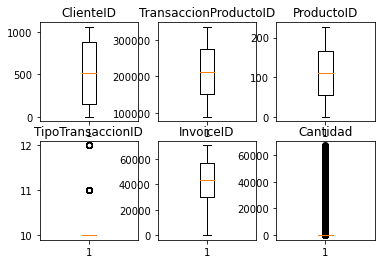

In [189]:
fig1, ax1 = plt.subplots(2,3)

ax1[0,0].set_title('ClienteID')
ax1[0,0].boxplot(np.array(movimientos_c.select('ClienteID').collect()))
ax1[0,1].set_title('TransaccionProductoID')
ax1[0,1].boxplot(np.array(movimientos_c.select('TransaccionProductoID').collect()))
ax1[0,2].set_title('ProductoID')
ax1[0,2].boxplot(np.array(movimientos_c.select('ProductoID').collect()))
ax1[1,0].set_title('TipoTransaccionID')
ax1[1,0].boxplot(np.array(movimientos_c.select('TipoTransaccionID').collect()))
ax1[1,1].set_title('InvoiceID')
ax1[1,1].boxplot(np.array(movimientos_c.select('InvoiceID').collect()))
ax1[1,2].set_title('Cantidad')
ax1[1,2].boxplot(np.array(movimientos_c.select('Cantidad').collect()))

In [191]:
reporte = ProfileReport(movimientos_c.toPandas())
reporte.to_file(PATH+"reporte_prefilamiento_movimientos.html")

Summarize dataset:  60%|██████    | 12/20 [00:02<00:01,  7.54it/s, Calculate kendall correlation]         C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 74.69it/s]


#### Consistencia
- verificación de llaves secundarias
- verificación de fechas deberian no ser futuras, no nulas ni vacias.


In [192]:
sql_producto = 'WWImportersTransactional.Producto'
sql_tipoTransaccion = 'WWImportersTransactional.TiposTransaccion'
sql_clientes = 'WWImportersTransactional.Clientes'
sql_proveedoresCopia = 'WWImportersTransactional.proveedoresCopia'
sql_OrdenesCopia= 'WWImportersTransactional.OrdenesCopia'

productos = obtener_dataframe_de_bd(db_connection_string, sql_producto, db_user, db_psswd)
tipoTransaccion = obtener_dataframe_de_bd(db_connection_string, sql_tipoTransaccion, db_user, db_psswd)
clientes = obtener_dataframe_de_bd(db_connection_string, sql_clientes, db_user, db_psswd)
proveedores = obtener_dataframe_de_bd(db_connection_string, sql_proveedoresCopia, db_user, db_psswd)
ordenes_ = obtener_dataframe_de_bd(db_connection_string, sql_OrdenesCopia, db_user, db_psswd)


In [194]:
producto_faltante_count = movimientos_c.join(productos, movimientos_c.ProductoID == productos.ID_Producto, "left_anti").count()
print(f"ProductoID faltantes: {producto_faltante_count}")

tipo_transaccion_faltante_count = movimientos_c.join(tipoTransaccion, movimientos_c.TipoTransaccionID == tipoTransaccion.TipoTransaccionID, "left_anti").count()
print(f"TipoTransaccionID faltantes: {tipo_transaccion_faltante_count}")

cliente_faltante_count = movimientos_c.join(clientes, movimientos_c.ClienteID == clientes.ID_Cliente, "left_anti").count()
print(f"ClienteID faltantes: {cliente_faltante_count}")

proveedor_faltante_count = movimientos_c.join(proveedores, movimientos_c.ProveedorID == proveedores.ProveedorID, "left_anti").count()
print(f"ProveedorID faltantes: {proveedor_faltante_count}")

orden_compra_faltante_count = movimientos_c.join(ordenes_, movimientos_c.OrdenDeCompraID == ordenes_.ID_de_pedido, "left_anti").count()
print(f"OrdenDeCompraID faltantes: {orden_compra_faltante_count}")


ProductoID faltantes: 0
TipoTransaccionID faltantes: 0
ClienteID faltantes: 7156
ProveedorID faltantes: 197182
OrdenDeCompraID faltantes: 204292


- verificación de fechas deberian no ser futuras, no nulas ni vacias.

In [198]:
from pyspark.sql.functions import current_date
movimientos_c.filter((col("FechaTransaccion").isNull()) |( col("FechaTransaccion") =="") | (col("FechaTransaccion") > current_date())).count()


0

- movimientos de 0 productos 
- movimiento de elementos negativos
- movimiento de elementos positos

In [200]:
movimientos_c.filter(col("Cantidad") < 0).count()


197158

In [201]:
movimientos_c.filter(col("Cantidad") >0).count()


7129

In [202]:
movimientos_c.filter(col("Cantidad") ==0).count()


5

### Conclusiones

#### *conclusiones y Acalaraciones de entendimiento general de los datos:*

1. En la tabla MovimientosCopia se presentan las siguientes columnas: identificador del producto, producto, tipo de transacción, cliente, invoice (identificador de la factura), proveedor, orden de compra, fecha de la transacción y cantidad.
2. Una fila representa la acción de mover cierta cantidad de productos (ingresados/retirados) del inventario en una fecha específica, teniendo en cuenta todos los detalles asociados al producto, como el cliente, la factura, el producto, el tipo de transacción, la orden de compra y el proveedor.
3. Se tienen 6 columnas numéricas, de las cuales 3 son enteros y 3 son booleanos, y hay otras 3 columnas que corresponden a cadenas de texto (strings). Una de los Strings corresponde a una fecha.
4. Los datos proporcionados corresponden a 204,292 movimientos.
5. ¿A qué tabla corresponde la llave foránea InvoiceID? En el diccionario de datos no se encuentra ninguna tabla con ese nombre ni con un nombre similar a "factura".
6. ¿La fecha de transacción es igual a la fecha de la orden de compra o de la factura, o es una fecha completamente diferente que se refiere a un proceso interno de manejo de inventario?



#### *Conclusiones de reglas de negocio:*

1. La regla 1 se cumple, ya que el negocio establece que la cantidad máxima de productos a ser movidos es de 50 millones. Según el resumen mostrado en la Imagen 1, la cantidad máxima es de 367,368, lo cual está por debajo de los 50 millones.

2. En base a la columna de cantidades, surge una duda: se puede notar que el valor mínimo es un número negativo de -360, y el percentil 50 tiene un valor de -9. Esto indica que hay números negativos dentro de esta columna. ¿Qué significan los números negativos? ¿Hacen referencia al retiro de inventario?¿ A que hace referencia una cantidad de 0?¿ por que existe esos registros ?

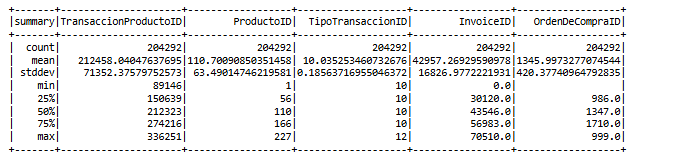
<p style="text-align: center;">Imagen 1</p>

3. El negocio nos informa que hay 236,668 movimientos de producto realizados desde 2013. Sin embargo, esto no parece correcto según los datos con los que estamos trabajando. A nivel general, solo contamos con 204,292 registros, de los cuales la fecha más lejana es del 31/12/2023, como se muestra en la Imagen 1. ¿Es posible que nos falten datos?

4. El negocio nos dice que los movimientos están relacionados con 228,265 clientes. Sin embargo, al revisar los datos proporcionados, podemos notar que solo tenemos movimientos para 664 clientes diferentes. ¿Es posible que nos falten datos?

5. Algunos formatos de fecha no coinciden con la regla 4, que establece que deben estar en el formato: YYYY-MM-DD HH:MM. Se puede evidenciar que hay 64,254 registros que no cumplen con este formato, pues hay fechas como "Apr 25, 2014" y "2013-12-31 07:00". Se propone cambiar el formato de aquellos que no tienen el formato establecido por el negocio.

6. Se menciona que se cuenta con 13 proveedores. Sin embargo, al realizar el conteo distintivo de los proveedores, podemos evidenciar que en los movimientos contamos únicamente con 4. En base a esto, surge la duda de si hay registros faltantes relacionados con los otros 9 proveedores, como se puede visualizar en la Imagen 2.

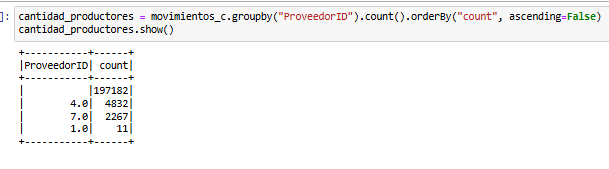
<p style="text-align: center;">Imagen 2</p>


7. En base al diagrama de correlación se podría considerar eliminar InvoiceID pues este tiene una muy alta correlación casi de 1  con la columna TransactionProductId el cual es llave primaria de los registros como se puede evidenciar en la imagen 3. En base a esto se hace la pregunta: ¿Es posible eliminar la columna InvoiceID?


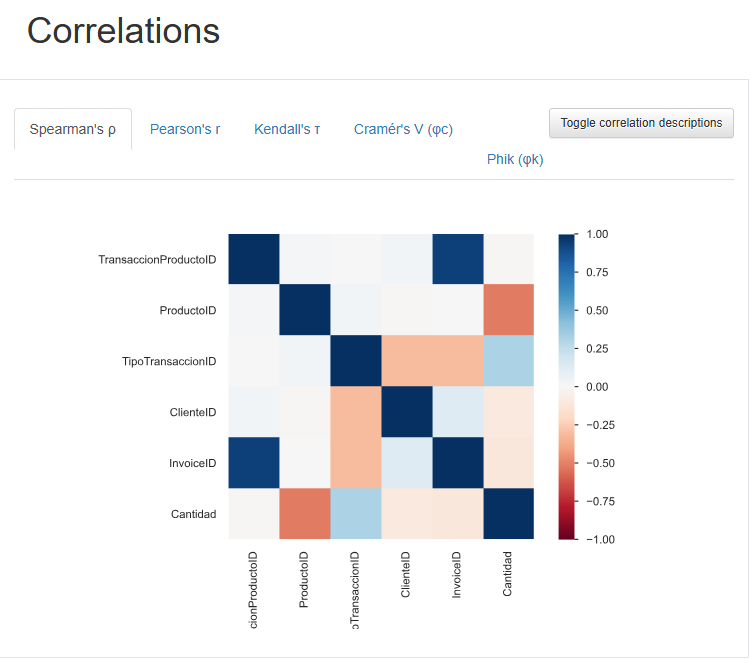
<p style="text-align: center;">Imagen 3</p>


#### *Conclusiones de calidad:*

#### *Completitud:*

En cuanto a la completitud, se puede decir que hay problemas, ya que hay ciertas columnas a las que les faltan datos. Entre ellas se encuentran:

1. 197,182 datos vacíos en el atributo OrdenDeCompraID.
2. 7,156 datos con la misma factura de 0.0. Esto nos genera dudas sobre si la factura 0.0 existe. En este caso, la completitud de esta columna sería del...
3. 7,156 registros asociados al cliente 0.0. Esto genera la pregunta de si el cliente 0.0 es un cliente válido.
4. 19,718 registros con un proveedor vacío.
En general, se puede decir que la completitud es:

- Completitud de ProveedorID: 3.48%
- Completitud de FechaTransaccion: 100.0%
- Completitud de Cantidad: 100.0%
- Completitud de ClienteID: 100.0%
- Completitud de TransaccionProductoID: 100.0%
- Completitud de ProductoID: 100.0%
- Completitud de TipoTransaccionID: 100.0%
- Completitud de InvoiceID: 96.50%
- Completitud de OrdenDeCompraID: 3.48%


En base en lo anterior, la pregunta sería al negocio si hay alguna forma de proveer los datos faltantes.

#### *Unicidad:*
Se hizo una revisión de aquellos registros en los que la mayoría de atributos, excluyendo la llave primaria, son únicos. Se ha notado que un 85% de los registros son únicos, lo cual equivale a 173,659 registros. Por otro lado, 30,633 registros no son únicos.

Basándonos en la imagen 4, podemos notar ciertas inconsistencias, ya que la llave primaria de ciertos registros está duplicada, lo cual no debería ocurrir.

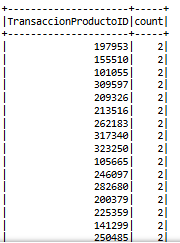
<p style="text-align: center;">Imagen 4</p>

Con base en lo anterior, se recomienda:

- Revisar las reglas dentro de la tabla en cuanto a la llave primaria.
- Proponer borrar o eliminar todos esos registros, que corresponden al 15% del total de registros.




#### *Validez:*
Se evidencian inconsistencias semánticas en cuanto a la estructura, ya que la fecha no es consistente para todos los registros. Como se ha mencionado antes, hay 64,254 datos que no cumplen con la estructura establecida.

Asimismo, podemos observar que hay valores negativos en la columna de cantidad. En caso de no tener un significado concreto, los valores negativos en cantidad indicarían un problema grave en términos de consistencia. A través de la imagen 5, podemos ver que estos podrían ser los valores inválidos, por lo que es importante determinar si es correcto tener valores negativos en esta columna.


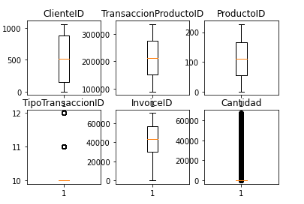


<p style="text-align: center;">Imagen 5</p>
#### Consistencia
- Se evidencia que al validar las llaves foraneas con las otras tablas hay problemas y coincide con el número de de nulos. Esto es epacialmente evidente en las columnas ClienteID, ProveedorID y OrdenDeCompraID como se puede evidenciar en la imagen 6. En base a esto se plantea la pregunta: ¿Hay forma de obtener estos datos faltantes? ¿ Se podría clasificar a los clientes sin llave foranea como clientes anonimos? ¿ Los proveedores sin referencia a la tabla de proveedores tienen algún significado? ¿Los registros sin ordenes de compra asociado a la tabla de orden tienen algún significado?

- En cuanto a la columna con fechas se puede evidenciar que si hay consistencia en cuanto a los valores que toman las fechas (No son valores futuros). Más sin embargo no cuentan con un formato consistente como se ha mencionado en la etapa de validez.
- En cuanto a la columna con el nombre "cantidad" se evidencia valores negativos e iguales a 0. Lo cual genera dudas que se han expresado desde el inicio: ¿Qué signfica estos valores? ¿son correctos valores nulos o negativos?

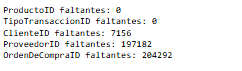
<p style="text-align: center;">Imagen 7</p>


#### Conclusión

**Conclusiones de consultoria**

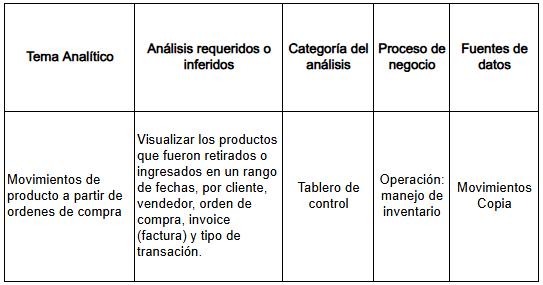
<p style="text-align: center;">Imagen 8</p>


Considerando el requerimiento que aparece en la Imagen 5, debido a los problemas de calidad con valores duplicados, se podría llegar a perder una buena cantidad de información, aproximadamente un 15% de los datos. En cuanto a la completitud, si bien hay una buena cantidad de columnas muy completas, los nulos de dos columnas en especifico pueden afectar dependiendo de las preguntas que se quieran resolver. Por ejemplo, en la columna de proveedor, solo contamos con un 3.4% de completitud, lo cual es bastante bajo.

En lo posible, lo mejor es realizar las correcciones necesarias para obtener mejores resultados en la elaboración de un tablero de control. Dependiendo de la relevancia de la información como proveedor y orden de compra en el tablero de control, si estos datos son muy importantes para el propósito del negocio, se podría concluir que no es viable crear el tablero de control sin corregir estos problemas de datos. En caso contrario, es importante considerar la posibilidad de asignar un valor de "Anónimo" o "Desconocido" a estos campos para poder construir el tablero de control y si en definitiva para orden no se ve como un campo necesario también se podría considerar eliminar esa información para la contrucción del tablero de control.


¿Qué funcionalidades de PySpark puedo utilizar para realizar el entendimiento de datos y cómo las puedo utilizar?
hay varias funciones que se pueden usar para el entendimiento de datos como lo son:

- sumary()
- toda sentencia SQL que perfita filtrar

¿Qué métodos podría utilizar para reemplazar los valores nulos de una columna por el promedio de la misma?
- na.fill(newValue)
- .fillna({'col':newValue})

## Cierre

Completado este tutorial ya sabrá la forma básica de utilizar PySpark. Ya sabe cómo crear DataFrames a partir de datos existentes, cómo seleccionar columnas o filas de este Dataframe, cómo rellenar espacios vacíos, cómo aplicar sus propias funciones a estos datos y los más importante, cómo utilizarlo para realizar una fase de entendimiento de datos.

Las tablas detallesOrdenesCopia y OrdenesCopia estaran disponibles en caso de que desee repetir este tutorial cuantas veces considere necesario

## 7. Información adicional

Si quiere conocer más sobre PySpark la guía más detallada es la documentación oficial, la cual puede encontrar acá: https://spark.apache.org/docs/latest/api/python/index.html <br>
Para ir directamente a la documentación de PySpark SQL, donde está la información sobre los DataFrames: https://spark.apache.org/docs/latest/api/python/pyspark.sql.html <br>

El Capítulo 2 del libro <i>Learn PySpark : Build Python-based Machine Learning and Deep Learning Models, New York: Apress. 2019</i> de Pramod Singh contiene muchos ejemplos útiles, puede encontrarlo en la biblioteca virtual de la universidad.

## 8. Preguntas frecuentes

1. Si en el cálculo de los histogramas o en una de sus UDF obtiene el error: TypeError: unsupported operand type(s) for *: 'decimal.Decimal' and 'float' verifique los tipos de las columnas que está intentando operar y, si alguna es double, conviértala a float.

2. En algunos casos, encontrará también información sobre <i>Pandas_UDF</i>. <i>Pandas_UDF</i> son también User Defined Functions, por lo general los Pandas UDF son más eficientes que los UDF tradicionales, sin embargo, hay un bug con la versión de PySpark y de Java que se está usando, lo que previene la utilización de Pandas_UDF.

3. Si al ejecutar la configuración de la sesión Spark le aparece el error <i>Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*])</i> Reinicie el kernel y vuelva a ejecutar
